<a href="https://colab.research.google.com/github/Areykal/Animal-Species-Identification/blob/main/Animal_Species_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages (if needed)
# !pip install -q tensorflow scikit-learn matplotlib seaborn pandas joblib

# Check TensorFlow installation and GPU availability
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
import joblib
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Basic parameters
IMG_SIZE = 224
BATCH_SIZE = 128
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

# Import required libraries
from keras.api.models import Model, Sequential
from keras.api.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.api.applications import MobileNetV3Small
from keras.api.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Mount Google Drive (if in Colab)
from google.colab import drive
drive.mount('/content/drive')

# Create directory for saving models
os.makedirs('/content/drive/MyDrive/animal_classifier', exist_ok=True)

# Dictionary to translate Italian class names to English
italian_to_english = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "scoiattolo": "squirrel",
    "ragno": "spider"
}

# Original Italian class names that match the dataset folders
classes_italian = ['cane', 'gatto', 'cavallo', 'ragno', 'farfalla',
                 'gallina', 'pecora', 'mucca', 'scoiattolo', 'elefante']

# English translations for display and reporting
classes_english = [italian_to_english[cls] for cls in classes_italian]

print("Italian class names:", classes_italian)
print("English translations:", classes_english)

# Set paths
train_data_dir = '/content/drive/MyDrive/animal_classifier/split_data/train'
val_data_dir = '/content/drive/MyDrive/animal_classifier/split_data/val'
test_data_dir = '/content/drive/MyDrive/animal_classifier/split_data/test'

# Define model paths
feature_extractor_path = '/content/drive/MyDrive/animal_classifier/feature_extractor.h5'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Italian class names: ['cane', 'gatto', 'cavallo', 'ragno', 'farfalla', 'gallina', 'pecora', 'mucca', 'scoiattolo', 'elefante']
English translations: ['dog', 'cat', 'horse', 'spider', 'butterfly', 'chicken', 'sheep', 'cow', 'squirrel', 'elephant']


In [ ]:
# Preprocessing function
preprocessing_layer = tf.keras.applications.mobilenet_v3.preprocess_input

def get_data_augmentation():
    """Create simplified augmentation pipeline"""
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2)
    ])

def create_dataset(data_dir, batch_size=BATCH_SIZE, training=False):
    """Create a dataset from directory"""
    dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        label_mode='categorical',
        shuffle=training,
        seed=42
    )

    # Store class names
    class_names = dataset.class_names
    print(f"Dataset created from {data_dir} with classes: {class_names}")

    # Calculate class weights for handling imbalance
    class_weight_dict = None
    if training:
        class_counts = {}
        for cls in class_names:
            class_dir = os.path.join(data_dir, cls)
            class_counts[cls] = len(os.listdir(class_dir))

        # Print class distribution
        print("Class distribution:")
        for cls, count in class_counts.items():
            print(f"  {cls}: {count} samples")

        # Store class weights for later use
        class_weight_dict = {}
        max_count = max(class_counts.values())
        for i, cls in enumerate(class_names):
            # Inverse frequency weighting
            class_weight_dict[i] = (max_count / class_counts[cls]) ** 0.5

        # Print class weights
        print("Class weights:")
        for i, w in class_weight_dict.items():
            print(f"  Class {i} ({class_names[i]}): {w:.2f}")

        # Save class weights
        with open('/content/drive/MyDrive/animal_classifier/class_weights.json', 'w') as f:
            json.dump({str(k): float(v) for k, v in class_weight_dict.items()}, f)

    # Simple preprocessing pipeline
    if training:
        # Apply preprocessing
        dataset = dataset.map(
            lambda x, y: (preprocessing_layer(x), y),
            num_parallel_calls=AUTOTUNE
        )

        # Apply augmentation
        data_augmentation = get_data_augmentation()
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x), y),
            num_parallel_calls=AUTOTUNE
        )

        # Cache, shuffle, repeat, prefetch
        dataset = dataset.cache().shuffle(1000).repeat().prefetch(AUTOTUNE)
    else:
        # For validation/test just preprocess
        dataset = dataset.map(
            lambda x, y: (preprocessing_layer(x), y),
            num_parallel_calls=AUTOTUNE
        ).cache().prefetch(AUTOTUNE)

    # Calculate steps
    num_samples = sum(len(os.listdir(os.path.join(data_dir, d)))
                      for d in os.listdir(data_dir)
                      if os.path.isdir(os.path.join(data_dir, d)))
    steps = num_samples // batch_size
    if num_samples % batch_size > 0:
        steps += 1

    return dataset, steps, num_samples, class_names

In [ ]:
# Create datasets
print("Creating datasets...")
train_dataset, train_steps, train_samples, train_class_names = create_dataset(train_data_dir, batch_size=BATCH_SIZE, training=True)
val_dataset, val_steps, val_samples, val_class_names = create_dataset(val_data_dir, batch_size=BATCH_SIZE, training=False)
test_dataset, test_steps, test_samples, test_class_names = create_dataset(test_data_dir, batch_size=BATCH_SIZE, training=False)

# Load class weights if available
class_weight_dict = None
if os.path.exists('/content/drive/MyDrive/animal_classifier/class_weights.json'):
    with open('/content/drive/MyDrive/animal_classifier/class_weights.json', 'r') as f:
        class_weight_dict = json.load(f)
        # Convert keys from strings to integers
        class_weight_dict = {int(k): float(v) for k, v in class_weight_dict.items()}

Creating datasets...
Found 18322 files belonging to 10 classes.
Dataset created from /content/drive/MyDrive/animal_classifier/split_data/train with classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Class distribution:
  cane: 3404 samples
  cavallo: 1836 samples
  elefante: 1012 samples
  farfalla: 1478 samples
  gallina: 2168 samples
  gatto: 1167 samples
  mucca: 1306 samples
  pecora: 1274 samples
  ragno: 3374 samples
  scoiattolo: 1303 samples
Class weights:
  Class 0 (cane): 1.00
  Class 1 (cavallo): 1.36
  Class 2 (elefante): 1.83
  Class 3 (farfalla): 1.52
  Class 4 (gallina): 1.25
  Class 5 (gatto): 1.71
  Class 6 (mucca): 1.61
  Class 7 (pecora): 1.63
  Class 8 (ragno): 1.00
  Class 9 (scoiattolo): 1.62
Found 3922 files belonging to 10 classes.
Dataset created from /content/drive/MyDrive/animal_classifier/split_data/val with classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecor

In [ ]:
# Create feature extractor model
print("\nCreating feature extractor model...")
# Base model - MobileNetV3Small with ImageNet weights
base_model = MobileNetV3Small(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Unfreeze all layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Create feature extractor model
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
feature_extractor = Model(inputs=inputs, outputs=x, name='feature_extractor')
print(f"Feature extractor output shape: {feature_extractor.output_shape}")

# Create model for training the feature extractor
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(len(classes_italian), activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Creating feature extractor model...
Feature extractor output shape: (None, 576)



Training feature extractor for 30 epochs...
Epoch 1/30
572/573 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4863 - loss: 2.1356
Epoch 1: val_accuracy improved from -inf to 0.90158, saving model to /content/drive/MyDrive/animal_classifier/feature_extractor.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 130s 76ms/step - accuracy: 0.4869 - loss: 2.1332 - val_accuracy: 0.9016 - val_loss: 0.3181 - learning_rate: 1.0000e-04
Epoch 2/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8454 - loss: 0.6544
Epoch 2: val_accuracy did not improve from 0.90158
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.8454 - loss: 0.6542 - val_accuracy: 0.8990 - val_loss: 0.3223 - learning_rate: 1.0000e-04
Epoch 3/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8992 - loss: 0.4319
Epoch 3: val_accuracy improved from 0.90158 to 0.92682, saving model to /content/drive/MyDrive/animal_classifier/feature_extractor.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.8992 - loss: 0.4319 - val_accuracy: 0.9268 - val_loss: 0.2408 - learning_rate: 1.0000e-04
Epoch 4/30
572/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9294 - loss: 0.2984
Epoch 4: val_accuracy improved from 0.92682 to 0.92835, saving model to /content/drive/MyDrive/animal_classifier/feature_extractor.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9295 - loss: 0.2984 - val_accuracy: 0.9284 - val_loss: 0.2470 - learning_rate: 1.0000e-04
Epoch 5/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9563 - loss: 0.1888
Epoch 5: val_accuracy did not improve from 0.92835
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9562 - loss: 0.1889 - val_accuracy: 0.9151 - val_loss: 0.3565 - learning_rate: 1.0000e-04
Epoch 6/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9690 - loss: 0.1294
Epoch 6: val_accuracy did not improve from 0.92835
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9690 - loss: 0.1294 - val_accuracy: 0.9215 - val_loss: 0.3447 - learning_rate: 1.0000e-04
Epoch 7/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9812 - loss: 0.0813
Epoch 7: val_accuracy did not improve from 0.92835
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9812 - loss: 0.0813 - val_accuracy: 0.9253 - val_loss: 0.3847 - learning_rate: 1.0000e-0

573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9963 - loss: 0.0181 - val_accuracy: 0.9289 - val_loss: 0.4364 - learning_rate: 5.0000e-05
Epoch 12/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9980 - loss: 0.0117
Epoch 12: val_accuracy did not improve from 0.92886
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9980 - loss: 0.0117 - val_accuracy: 0.9276 - val_loss: 0.4819 - learning_rate: 5.0000e-05
Epoch 13/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9984 - loss: 0.0088
Epoch 13: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 13: val_accuracy did not improve from 0.92886
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9984 - loss: 0.0088 - val_accuracy: 0.9289 - val_loss: 0.4811 - learning_rate: 5.0000e-05
Epoch 14/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9979 - loss: 0.0085
Epoch 14: val_accuracy improved from 0.92886 to 0.92937, saving model to /content/drive/MyDrive/animal_classifier

573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9979 - loss: 0.0085 - val_accuracy: 0.9294 - val_loss: 0.4842 - learning_rate: 2.5000e-05
Epoch 15/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9991 - loss: 0.0048
Epoch 15: val_accuracy improved from 0.92937 to 0.92963, saving model to /content/drive/MyDrive/animal_classifier/feature_extractor.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9991 - loss: 0.0048 - val_accuracy: 0.9296 - val_loss: 0.4990 - learning_rate: 2.5000e-05
Epoch 16/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9987 - loss: 0.0055
Epoch 16: val_accuracy improved from 0.92963 to 0.93039, saving model to /content/drive/MyDrive/animal_classifier/feature_extractor.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9987 - loss: 0.0055 - val_accuracy: 0.9304 - val_loss: 0.5140 - learning_rate: 2.5000e-05
Epoch 17/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9989 - loss: 0.0053
Epoch 17: val_accuracy did not improve from 0.93039
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9989 - loss: 0.0053 - val_accuracy: 0.9240 - val_loss: 0.5375 - learning_rate: 2.5000e-05
Epoch 18/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9992 - loss: 0.0043
Epoch 18: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 18: val_accuracy did not improve from 0.93039
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9992 - loss: 0.0043 - val_accuracy: 0.9291 - val_loss: 0.5349 - learning_rate: 2.5000e-05
Epoch 19/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9996 - loss: 0.0029
Epoch 19: val_accuracy did not improve from 0.93039
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9996

Feature extractor training completed in 417.74 seconds
Feature extractor saved to: /content/drive/MyDrive/animal_classifier/feature_extractor.h5


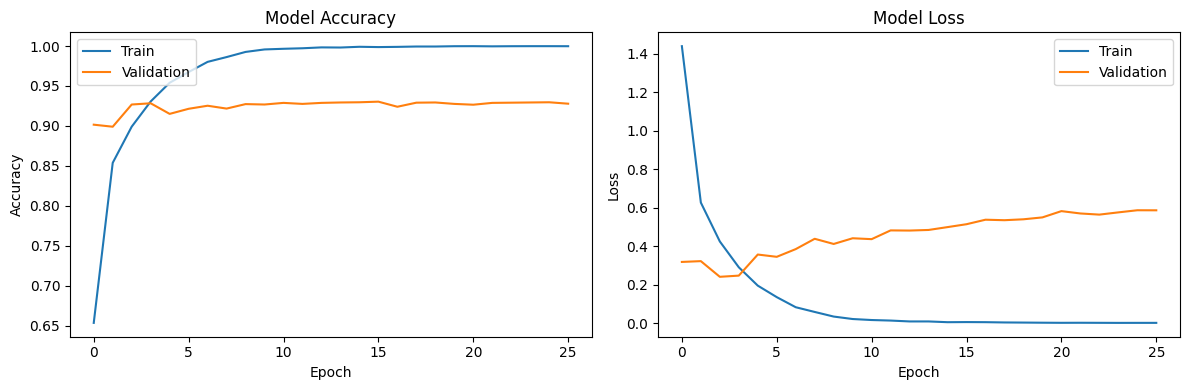

In [ ]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(feature_extractor_path, monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Train model
print(f"\nTraining feature extractor for {EPOCHS} epochs...")
start_time = time.time()

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_data=val_dataset,
    validation_steps=val_steps,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

training_time = time.time() - start_time
print(f"Feature extractor training completed in {training_time:.2f} seconds")

# Save feature extractor
feature_extractor.save(feature_extractor_path)
print(f"Feature extractor saved to: {feature_extractor_path}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/animal_classifier/training_history.png')
plt.show()

In [ ]:
# Function to extract features using the trained extractor
def extract_features(dataset, steps, feature_extractor):
    """Extract features from a dataset efficiently"""
    all_features = []
    all_labels = []

    print(f"Extracting features from {steps} batches...")

    for batch_idx, (images, labels) in enumerate(dataset.take(steps)):
        # Get features for this batch
        features = feature_extractor.predict(images, verbose=0)

        # Convert to numpy arrays
        features_np = features
        labels_np = labels.numpy()

        # Store
        all_features.append(features_np)
        all_labels.append(labels_np)

        # Report progress
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == steps:
            print(f"Processed {batch_idx + 1}/{steps} batches")

    # Combine all batches
    features = np.vstack(all_features)
    labels = np.vstack(all_labels)

    return features, labels

# Define file paths for extracted features
train_features_path = '/content/drive/MyDrive/animal_classifier/train_features.npy'
train_labels_path = '/content/drive/MyDrive/animal_classifier/train_labels.npy'
val_features_path = '/content/drive/MyDrive/animal_classifier/val_features.npy'
val_labels_path = '/content/drive/MyDrive/animal_classifier/val_labels.npy'
test_features_path = '/content/drive/MyDrive/animal_classifier/test_features.npy'
test_labels_path = '/content/drive/MyDrive/animal_classifier/test_labels.npy'

# Check if features already exist or extract them
if (os.path.exists(train_features_path) and os.path.exists(train_labels_path) and
    os.path.exists(val_features_path) and os.path.exists(val_labels_path) and
    os.path.exists(test_features_path) and os.path.exists(test_labels_path)):

    print("Loading pre-extracted features...")
    train_features = np.load(train_features_path)
    train_labels = np.load(train_labels_path)
    val_features = np.load(val_features_path)
    val_labels = np.load(val_labels_path)
    test_features = np.load(test_features_path)
    test_labels = np.load(test_labels_path)

    # Convert to indices if they are one-hot encoded
    if len(train_labels.shape) > 1 and train_labels.shape[1] > 1:
        print("Converting one-hot encoded labels to indices...")
        train_labels_idx = np.argmax(train_labels, axis=1)
        val_labels_idx = np.argmax(val_labels, axis=1)
        test_labels_idx = np.argmax(test_labels, axis=1)
    else:
        train_labels_idx = train_labels
        val_labels_idx = val_labels
        test_labels_idx = test_labels
else:
    print("Extracting features...")
    start_time = time.time()

    # Extract features for each dataset
    print("\nExtracting training features...")
    train_features, train_labels = extract_features(train_dataset, train_steps, feature_extractor)

    print("\nExtracting validation features...")
    val_features, val_labels = extract_features(val_dataset, val_steps, feature_extractor)

    print("\nExtracting test features...")
    test_features, test_labels = extract_features(test_dataset, test_steps, feature_extractor)

    # Convert to indices
    train_labels_idx = np.argmax(train_labels, axis=1)
    val_labels_idx = np.argmax(val_labels, axis=1)
    test_labels_idx = np.argmax(test_labels, axis=1)

    # Save features and labels
    np.save(train_features_path, train_features)
    np.save(train_labels_path, train_labels_idx)
    np.save(val_features_path, val_features)
    np.save(val_labels_path, val_labels_idx)
    np.save(test_features_path, test_features)
    np.save(test_labels_path, test_labels_idx)

    extraction_time = time.time() - start_time
    print(f"Feature extraction completed in {extraction_time:.2f} seconds")

# Print feature shapes
print(f"Feature shapes: Train {train_features.shape}, Val {val_features.shape}, Test {test_features.shape}")

Loading pre-extracted features...
Feature shapes: Train (18322, 576), Val (3922, 576), Test (3935, 576)



Training and evaluating classifiers...

Training SVM...
Validation accuracy: 0.9378
Test accuracy: 0.9367
Training time: 34.03 seconds
Average inference time: 1.08 ms

Classification Report:
              precision    recall  f1-score   support

         dog       0.95      0.92      0.94       730
         cat       0.90      0.92      0.91       394
       horse       0.93      0.96      0.95       218
      spider       0.93      0.98      0.95       318
   butterfly       0.95      0.97      0.96       466
     chicken       0.95      0.90      0.92       251
       sheep       0.85      0.86      0.86       281
         cow       0.88      0.88      0.88       273
    squirrel       0.99      0.98      0.98       724
    elephant       0.95      0.94      0.95       280

    accuracy                           0.94      3935
   macro avg       0.93      0.93      0.93      3935
weighted avg       0.94      0.94      0.94      3935


Training Random Forest...
Validation accuracy: 0

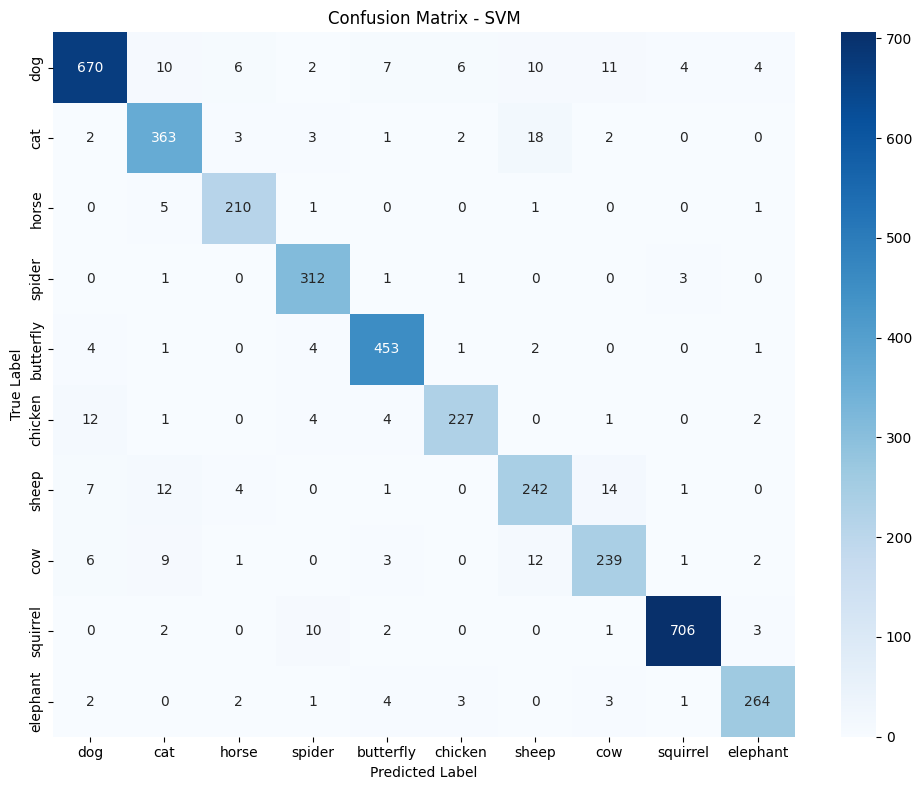

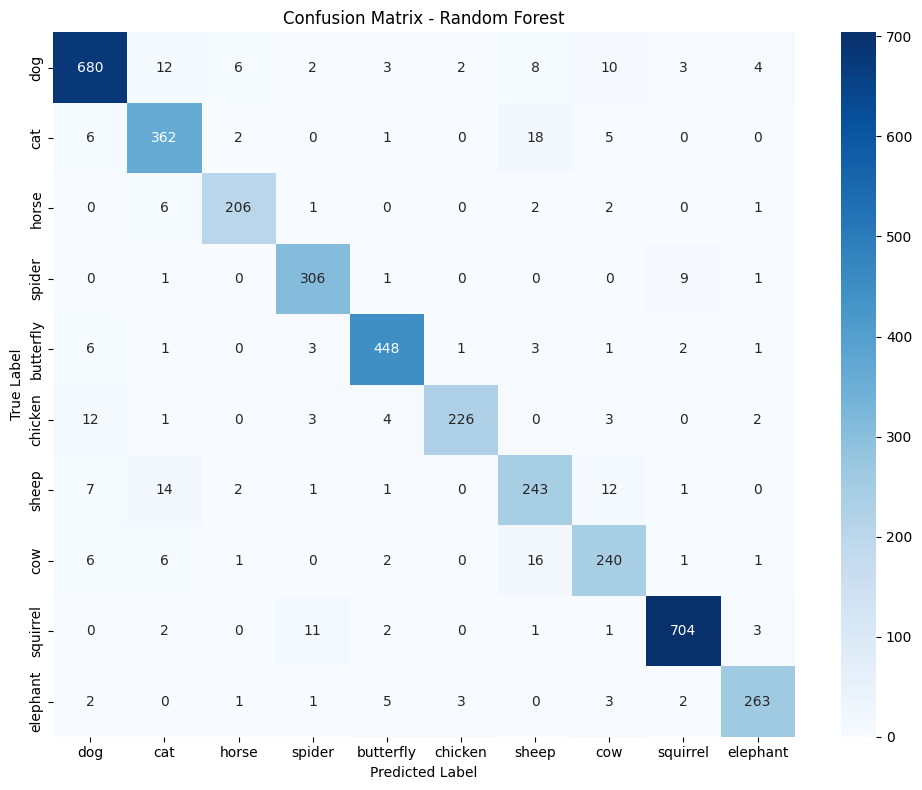

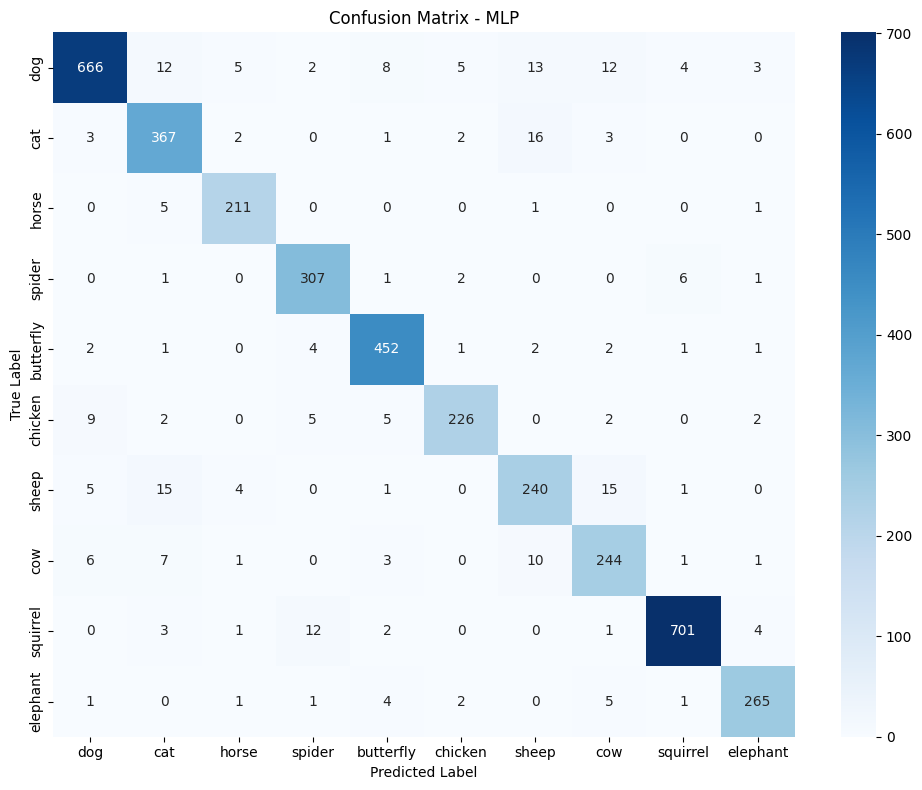

In [ ]:
# Define classifiers
classifiers = {
    'SVM': SVC(
        probability=True,
        C=10.0,
        gamma='scale',
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight='balanced',
        n_jobs=-1
    ),
    'MLP': MLPClassifier(
        hidden_layer_sizes=(256, 128),
        activation='relu',
        solver='adam',
        alpha=0.0001,
        batch_size='auto',
        learning_rate='adaptive',
        max_iter=1000,
        early_stopping=True
    )
}

# Train and evaluate classifiers
print("\nTraining and evaluating classifiers...")
results = {}

for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    start_time = time.time()

    # Train the classifier
    clf.fit(train_features, train_labels_idx)

    # Predict on validation set
    val_pred = clf.predict(val_features)
    val_accuracy = accuracy_score(val_labels_idx, val_pred)

    # Predict on test set
    test_pred = clf.predict(test_features)
    test_accuracy = accuracy_score(test_labels_idx, test_pred)

    training_time = time.time() - start_time

    # Measure inference time (average of 10 predictions)
    inference_times = []
    for _ in range(10):
        start = time.time()
        _ = clf.predict(test_features[:1])
        end = time.time()
        inference_times.append(end - start)
    avg_inference_time = np.mean(inference_times)

    # Store results
    results[name] = {
        'val_accuracy': val_accuracy,
        'test_accuracy': test_accuracy,
        'training_time': training_time,
        'inference_time': avg_inference_time,
        'model': clf
    }

    print(f"Validation accuracy: {val_accuracy:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Average inference time: {avg_inference_time*1000:.2f} ms")

    # Save classifier
    joblib.dump(clf, f'/content/drive/MyDrive/animal_classifier/{name.lower().replace(" ", "_")}_classifier.pkl')

    # Generate confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(test_labels_idx, test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes_english, yticklabels=classes_english)
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/animal_classifier/confusion_matrix_{name.lower().replace(" ", "_")}.png')

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(test_labels_idx, test_pred, target_names=classes_english))


Best classifier: SVM
Test accuracy: 0.9367
Inference time: 1.08 ms

Classifier Performance Comparison:
      Classifier  Validation Accuracy  Test Accuracy  Training Time (s)  \
0            SVM             0.937787       0.936722          34.026681   
1  Random Forest             0.936002       0.934689           7.300102   
2            MLP             0.934982       0.934943           7.240695   

   Inference Time (ms)  
0             1.076531  
1            21.412659  
2             0.329399  


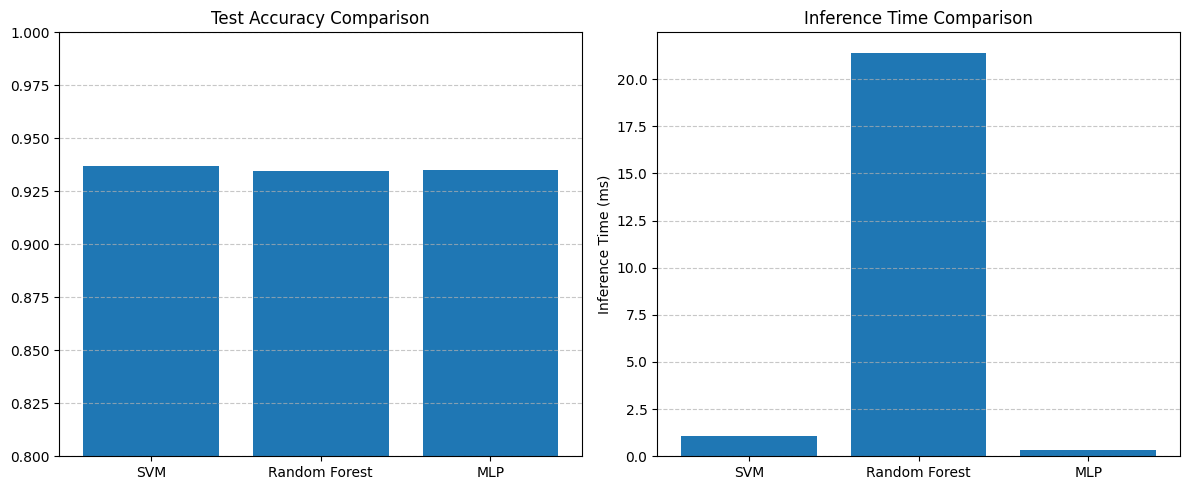


All models and results saved to Google Drive at: /content/drive/MyDrive/animal_classifier/


In [ ]:
# Find best classifier
best_classifier_name = max(results, key=lambda x: results[x]['test_accuracy'])
print(f"\nBest classifier: {best_classifier_name}")
print(f"Test accuracy: {results[best_classifier_name]['test_accuracy']:.4f}")
print(f"Inference time: {results[best_classifier_name]['inference_time']*1000:.2f} ms")

# Create a results dataframe for comparison
result_data = {
    'Classifier': [],
    'Validation Accuracy': [],
    'Test Accuracy': [],
    'Training Time (s)': [],
    'Inference Time (ms)': []
}

for name, data in results.items():
    result_data['Classifier'].append(name)
    result_data['Validation Accuracy'].append(data['val_accuracy'])
    result_data['Test Accuracy'].append(data['test_accuracy'])
    result_data['Training Time (s)'].append(data['training_time'])
    result_data['Inference Time (ms)'].append(data['inference_time'] * 1000)

results_df = pd.DataFrame(result_data)
print("\nClassifier Performance Comparison:")
print(results_df)

# Plot accuracy comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(result_data['Classifier'], result_data['Test Accuracy'])
plt.title('Test Accuracy Comparison')
plt.ylim(0.8, 1.0)  # Adjust as needed
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.bar(result_data['Classifier'], result_data['Inference Time (ms)'])
plt.title('Inference Time Comparison')
plt.ylabel('Inference Time (ms)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/animal_classifier/classifier_comparison.png')
plt.show()

# Save results summary
results_summary = {name: {k: v for k, v in data.items() if k != 'model'} for name, data in results.items()}
with open('/content/drive/MyDrive/animal_classifier/classifier_results.json', 'w') as f:
    json.dump(results_summary, f, indent=4)

print("\nAll models and results saved to Google Drive at: /content/drive/MyDrive/animal_classifier/")

Creating end-to-end model...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,239,674 (4.73 MB)

 Trainable params: 1,227,562 (4.68 MB)

 Non-trainable params: 12,112 (47.31 KB)


Training end-to-end model for 30 epochs...
Epoch 1/30
572/573 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4618 - loss: 2.2082
Epoch 1: val_accuracy improved from -inf to 0.90031, saving model to /content/drive/MyDrive/animal_classifier/end_to_end_model.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 82s 69ms/step - accuracy: 0.4625 - loss: 2.2057 - val_accuracy: 0.9003 - val_loss: 0.3327 - learning_rate: 1.0000e-04
Epoch 2/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8367 - loss: 0.6906
Epoch 2: val_accuracy improved from 0.90031 to 0.91917, saving model to /content/drive/MyDrive/animal_classifier/end_to_end_model.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8368 - loss: 0.6904 - val_accuracy: 0.9192 - val_loss: 0.2689 - learning_rate: 1.0000e-04
Epoch 3/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9014 - loss: 0.4185
Epoch 3: val_accuracy did not improve from 0.91917
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9013 - loss: 0.4186 - val_accuracy: 0.9192 - val_loss: 0.2663 - learning_rate: 1.0000e-04
Epoch 4/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9319 - loss: 0.2841
Epoch 4: val_accuracy improved from 0.91917 to 0.92759, saving model to /content/drive/MyDrive/animal_classifier/end_to_end_model.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9319 - loss: 0.2842 - val_accuracy: 0.9276 - val_loss: 0.2574 - learning_rate: 1.0000e-04
Epoch 5/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9541 - loss: 0.1927
Epoch 5: val_accuracy improved from 0.92759 to 0.92912, saving model to /content/drive/MyDrive/animal_classifier/end_to_end_model.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9541 - loss: 0.1927 - val_accuracy: 0.9291 - val_loss: 0.2750 - learning_rate: 1.0000e-04
Epoch 6/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9726 - loss: 0.1177
Epoch 6: val_accuracy did not improve from 0.92912
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9726 - loss: 0.1177 - val_accuracy: 0.9164 - val_loss: 0.3490 - learning_rate: 1.0000e-04
Epoch 7/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9813 - loss: 0.0812
Epoch 7: val_accuracy did not improve from 0.92912
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9813 - loss: 0.0813 - val_accuracy: 0.9261 - val_loss: 0.3237 - learning_rate: 1.0000e-04
Epoch 8/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9851 - loss: 0.0603
Epoch 8: val_accuracy did not improve from 0.92912
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9851 - loss: 0.0603 - val_accuracy: 0.9164 - val_loss: 0.4222 - learning_rate: 1.0000e-0

573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9964 - loss: 0.0180 - val_accuracy: 0.9299 - val_loss: 0.4176 - learning_rate: 5.0000e-05
Epoch 12/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9977 - loss: 0.0120
Epoch 12: val_accuracy did not improve from 0.92988
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9977 - loss: 0.0120 - val_accuracy: 0.9299 - val_loss: 0.4640 - learning_rate: 5.0000e-05
Epoch 13/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9983 - loss: 0.0084
Epoch 13: val_accuracy did not improve from 0.92988
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9983 - loss: 0.0084 - val_accuracy: 0.9289 - val_loss: 0.4457 - learning_rate: 5.0000e-05
Epoch 14/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9984 - loss: 0.0075
Epoch 14: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 14: val_accuracy did not improve from 0.92988
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9984

573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9985 - loss: 0.0054 - val_accuracy: 0.9312 - val_loss: 0.4906 - learning_rate: 2.5000e-05
Epoch 16/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9987 - loss: 0.0063
Epoch 16: val_accuracy did not improve from 0.93116
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9987 - loss: 0.0063 - val_accuracy: 0.9299 - val_loss: 0.5203 - learning_rate: 2.5000e-05
Epoch 17/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9990 - loss: 0.0047
Epoch 17: val_accuracy improved from 0.93116 to 0.93422, saving model to /content/drive/MyDrive/animal_classifier/end_to_end_model.h5


573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9990 - loss: 0.0047 - val_accuracy: 0.9342 - val_loss: 0.5179 - learning_rate: 2.5000e-05
Epoch 18/30
572/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9987 - loss: 0.0060
Epoch 18: val_accuracy did not improve from 0.93422
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9987 - loss: 0.0060 - val_accuracy: 0.9284 - val_loss: 0.5319 - learning_rate: 2.5000e-05
Epoch 19/30
571/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9997 - loss: 0.0026
Epoch 19: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 19: val_accuracy did not improve from 0.93422
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9997 - loss: 0.0026 - val_accuracy: 0.9278 - val_loss: 0.5458 - learning_rate: 2.5000e-05
Epoch 20/30
572/573 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9996 - loss: 0.0021
Epoch 20: val_accuracy did not improve from 0.93422
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9996

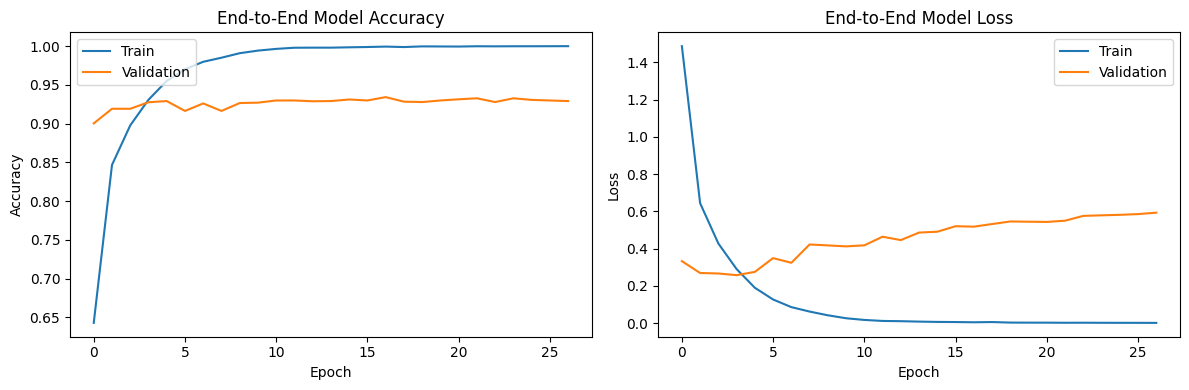


Evaluating end-to-end model on test set...
123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9319 - loss: 0.4651
End-to-end model test accuracy: 0.9329
End-to-end model average inference time: 73.34 ms


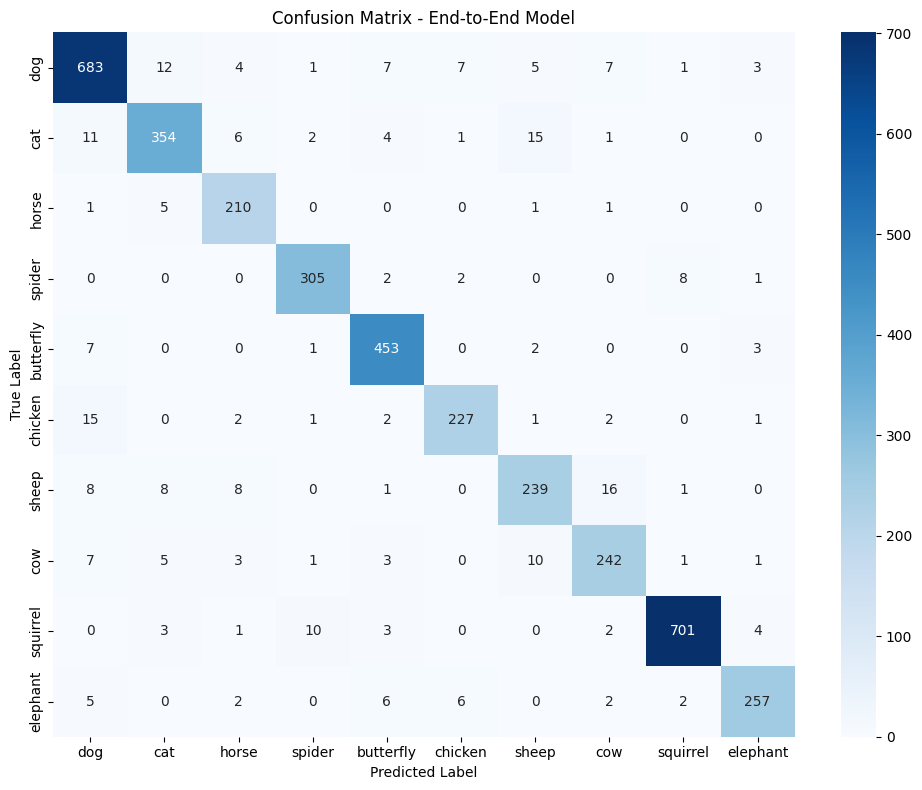


End-to-End Model Classification Report:
              precision    recall  f1-score   support

         dog       0.93      0.94      0.93       730
         cat       0.91      0.90      0.91       394
       horse       0.89      0.96      0.93       218
      spider       0.95      0.96      0.95       318
   butterfly       0.94      0.97      0.96       466
     chicken       0.93      0.90      0.92       251
       sheep       0.88      0.85      0.86       281
         cow       0.89      0.89      0.89       273
    squirrel       0.98      0.97      0.97       724
    elephant       0.95      0.92      0.93       280

    accuracy                           0.93      3935
   macro avg       0.93      0.93      0.93      3935
weighted avg       0.93      0.93      0.93      3935


Model Comparison:
                Model  Test Accuracy  Inference Time (ms)  Model Size (MB)
0  Two-Model Approach       0.936722            72.824192         10.74129
1    End-to-End Model       0.9

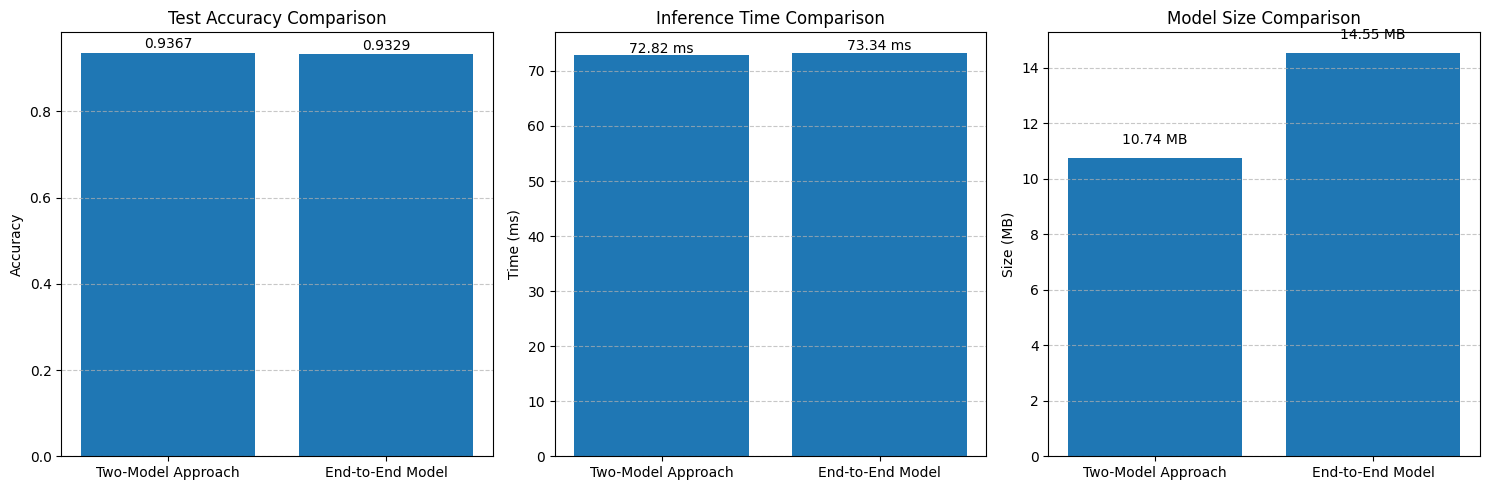


Performance Comparison Summary:
The Two-Model approach is 0.41% better in accuracy
The Two-Model approach is 0.71% faster in inference time
The Two-Model approach is 26.16% smaller in model size

Comparison results saved to Google Drive


In [ ]:
# End-to-End Model Implementation and Comparison

# Model paths
e2e_model_path = '/content/drive/MyDrive/animal_classifier/end_to_end_model.h5'

# Create an end-to-end model based on MobileNetV3Small
def create_end_to_end_model():
    """Create end-to-end model based on MobileNetV3Small"""
    # Base model
    base_model = MobileNetV3Small(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Unfreeze the top layers for fine-tuning
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    # Create full model with classification head
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(len(classes_italian), activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the end-to-end model
print("Creating end-to-end model...")
end_to_end_model = create_end_to_end_model()
end_to_end_model.summary()

# Define callbacks for end-to-end model
e2e_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint(e2e_model_path, monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Train the end-to-end model
print(f"\nTraining end-to-end model for {EPOCHS} epochs...")
e2e_start_time = time.time()

e2e_history = end_to_end_model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_data=val_dataset,
    validation_steps=val_steps,
    callbacks=e2e_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

e2e_training_time = time.time() - e2e_start_time
print(f"End-to-end model training completed in {e2e_training_time:.2f} seconds")

# Plot end-to-end training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(e2e_history.history['accuracy'])
plt.plot(e2e_history.history['val_accuracy'])
plt.title('End-to-End Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(e2e_history.history['loss'])
plt.plot(e2e_history.history['val_loss'])
plt.title('End-to-End Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/animal_classifier/e2e_training_history.png')
plt.show()

# Evaluate end-to-end model on test set
print("\nEvaluating end-to-end model on test set...")
e2e_test_loss, e2e_test_accuracy = end_to_end_model.evaluate(test_dataset, steps=test_steps)
print(f"End-to-end model test accuracy: {e2e_test_accuracy:.4f}")

# Measure end-to-end inference time
e2e_inference_times = []
for images, _ in test_dataset.take(1):
    sample_image = images[0:1]  # Take just one image

    # Warm-up prediction
    _ = end_to_end_model.predict(sample_image, verbose=0)

    # Timed predictions
    for _ in range(10):
        start = time.time()
        _ = end_to_end_model.predict(sample_image, verbose=0)
        end = time.time()
        e2e_inference_times.append(end - start)

e2e_avg_inference_time = np.mean(e2e_inference_times)
print(f"End-to-end model average inference time: {e2e_avg_inference_time*1000:.2f} ms")

# Get end-to-end model predictions for confusion matrix
e2e_predictions = []
e2e_true_labels = []

for images, labels in test_dataset:
    # Get predictions
    preds = end_to_end_model.predict(images, verbose=0)
    pred_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    # Add to lists
    e2e_predictions.extend(pred_classes)
    e2e_true_labels.extend(true_classes)

# Convert to arrays
e2e_predictions = np.array(e2e_predictions)
e2e_true_labels = np.array(e2e_true_labels)

# Calculate end-to-end model metrics
e2e_accuracy = accuracy_score(e2e_true_labels, e2e_predictions)

# Generate end-to-end confusion matrix
plt.figure(figsize=(10, 8))
e2e_cm = confusion_matrix(e2e_true_labels, e2e_predictions)
sns.heatmap(e2e_cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes_english, yticklabels=classes_english)
plt.title('Confusion Matrix - End-to-End Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/animal_classifier/confusion_matrix_e2e.png')
plt.show()

# Print end-to-end classification report
print("\nEnd-to-End Model Classification Report:")
print(classification_report(e2e_true_labels, e2e_predictions, target_names=classes_english))

# Compare two-model approach with end-to-end model
best_two_model_accuracy = results[best_classifier_name]['test_accuracy']
best_two_model_inference_time = results[best_classifier_name]['inference_time'] * 1000  # Convert to ms
feature_extractor_inference_time = 0  # We'll measure this now

# Measure feature extractor inference time
fe_inference_times = []
for images, _ in test_dataset.take(1):
    sample_image = images[0:1]  # Take just one image

    # Warm-up prediction
    _ = feature_extractor.predict(sample_image, verbose=0)

    # Timed predictions
    for _ in range(10):
        start = time.time()
        _ = feature_extractor.predict(sample_image, verbose=0)
        end = time.time()
        fe_inference_times.append(end - start)

feature_extractor_inference_time = np.mean(fe_inference_times) * 1000  # Convert to ms

# Total two-model inference time (feature extractor + classifier)
total_two_model_inference_time = feature_extractor_inference_time + best_two_model_inference_time

# Create comparison data
comparison_data = {
    'Model': ['Two-Model Approach', 'End-to-End Model'],
    'Test Accuracy': [best_two_model_accuracy, e2e_accuracy],
    'Inference Time (ms)': [total_two_model_inference_time, e2e_avg_inference_time * 1000],
    'Model Size (MB)': [
        (os.path.getsize(feature_extractor_path) +
         os.path.getsize(f'/content/drive/MyDrive/animal_classifier/{best_classifier_name.lower().replace(" ", "_")}_classifier.pkl')) / (1024 * 1024),
        os.path.getsize(e2e_model_path) / (1024 * 1024)
    ]
}

# Create comparison dataframe
comparison_df = pd.DataFrame(comparison_data)
print("\nModel Comparison:")
print(comparison_df)

# Plot comparison
plt.figure(figsize=(15, 5))

# Accuracy comparison
plt.subplot(1, 3, 1)
plt.bar(comparison_data['Model'], comparison_data['Test Accuracy'])
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
for i, v in enumerate(comparison_data['Test Accuracy']):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Inference time comparison
plt.subplot(1, 3, 2)
plt.bar(comparison_data['Model'], comparison_data['Inference Time (ms)'])
plt.title('Inference Time Comparison')
plt.ylabel('Time (ms)')
for i, v in enumerate(comparison_data['Inference Time (ms)']):
    plt.text(i, v + 0.5, f'{v:.2f} ms', ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Model size comparison
plt.subplot(1, 3, 3)
plt.bar(comparison_data['Model'], comparison_data['Model Size (MB)'])
plt.title('Model Size Comparison')
plt.ylabel('Size (MB)')
for i, v in enumerate(comparison_data['Model Size (MB)']):
    plt.text(i, v + 0.5, f'{v:.2f} MB', ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/animal_classifier/model_comparison.png')
plt.show()

# Calculate percentage differences
accuracy_diff = ((best_two_model_accuracy / e2e_accuracy) - 1) * 100
time_diff = ((total_two_model_inference_time / (e2e_avg_inference_time * 1000)) - 1) * 100
size_diff = ((comparison_data['Model Size (MB)'][0] / comparison_data['Model Size (MB)'][1]) - 1) * 100

print("\nPerformance Comparison Summary:")
print(f"The Two-Model approach is {abs(accuracy_diff):.2f}% {'better' if accuracy_diff > 0 else 'worse'} in accuracy")
print(f"The Two-Model approach is {abs(time_diff):.2f}% {'slower' if time_diff > 0 else 'faster'} in inference time")
print(f"The Two-Model approach is {abs(size_diff):.2f}% {'larger' if size_diff > 0 else 'smaller'} in model size")

# Save comparison results
comparison_result = {
    'two_model': {
        'best_classifier': best_classifier_name,
        'accuracy': float(best_two_model_accuracy),
        'inference_time_ms': float(total_two_model_inference_time),
        'model_size_mb': float(comparison_data['Model Size (MB)'][0])
    },
    'end_to_end': {
        'accuracy': float(e2e_accuracy),
        'inference_time_ms': float(e2e_avg_inference_time * 1000),
        'model_size_mb': float(comparison_data['Model Size (MB)'][1])
    },
    'comparison': {
        'accuracy_diff_percent': float(accuracy_diff),
        'time_diff_percent': float(time_diff),
        'size_diff_percent': float(size_diff)
    }
}

with open('/content/drive/MyDrive/animal_classifier/model_comparison_results.json', 'w') as f:
    json.dump(comparison_result, f, indent=4)

print("\nComparison results saved to Google Drive")